# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [2]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# magic word for producing visualizations in notebook
%matplotlib inline

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

from matplotlib.pyplot import figure
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Imputer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [3]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep=';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep=';')

In [4]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).

#check the number of rows and columns in the data
azdias.shape

(891221, 85)

In [4]:
azdias.head(10)

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
5,3,1,2,2.0,3,1,5,2,2,5,...,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0
6,-1,2,2,5.0,1,5,1,5,4,3,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,4.0,6.0,3.0
7,-1,1,1,3.0,3,3,4,1,3,2,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,2.0,5.0,2.0
8,-1,3,1,3.0,4,4,2,4,2,2,...,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,4.0,3.0
9,-1,3,2,4.0,2,4,2,3,5,4,...,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,3.0,1.0


In [4]:
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
AGER_TYP                 891221 non-null int64
ALTERSKATEGORIE_GROB     891221 non-null int64
ANREDE_KZ                891221 non-null int64
CJT_GESAMTTYP            886367 non-null float64
FINANZ_MINIMALIST        891221 non-null int64
FINANZ_SPARER            891221 non-null int64
FINANZ_VORSORGER         891221 non-null int64
FINANZ_ANLEGER           891221 non-null int64
FINANZ_UNAUFFAELLIGER    891221 non-null int64
FINANZ_HAUSBAUER         891221 non-null int64
FINANZTYP                891221 non-null int64
GEBURTSJAHR              891221 non-null int64
GFK_URLAUBERTYP          886367 non-null float64
GREEN_AVANTGARDE         891221 non-null int64
HEALTH_TYP               891221 non-null int64
LP_LEBENSPHASE_FEIN      886367 non-null float64
LP_LEBENSPHASE_GROB      886367 non-null float64
LP_FAMILIE_FEIN          886367 non-null float64
LP_FAMILIE_GROB          886367 n

In [5]:
azdias.describe()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,891221.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,...,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,794005.000000,794005.000000,794005.00000
mean,-0.358435,2.777398,1.522098,3.632838,3.074528,2.821039,3.401106,3.033328,2.874167,3.075121,...,2.253330,2.801858,1.595426,0.699166,1.943913,3.612821,3.381087,3.167854,5.293002,3.07222
std,1.198724,1.068775,0.499512,1.595021,1.321055,1.464749,1.322134,1.529603,1.486731,1.353248,...,0.972008,0.920309,0.986736,0.727137,1.459654,0.973967,1.111598,1.002376,2.303739,1.36298
min,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.00000
25%,-1.000000,2.000000,1.000000,2.000000,2.000000,1.000000,3.000000,2.000000,2.000000,2.000000,...,1.000000,2.000000,1.000000,0.000000,1.000000,3.000000,3.000000,3.000000,4.000000,2.00000
50%,-1.000000,3.000000,2.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,...,2.000000,3.000000,2.000000,1.000000,1.000000,4.000000,3.000000,3.000000,5.000000,3.00000
75%,-1.000000,4.000000,2.000000,5.000000,4.000000,4.000000,5.000000,5.000000,4.000000,4.000000,...,3.000000,3.000000,2.000000,1.000000,3.000000,4.000000,4.000000,4.000000,7.000000,4.00000
max,3.000000,9.000000,2.000000,6.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,4.000000,4.000000,3.000000,2.000000,5.000000,5.000000,5.000000,9.000000,9.000000,9.00000


In [7]:
feat_info.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


In [8]:
feat_info.shape

(85, 4)

In [9]:
feat_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85 entries, 0 to 84
Data columns (total 4 columns):
attribute             85 non-null object
information_level     85 non-null object
type                  85 non-null object
missing_or_unknown    85 non-null object
dtypes: object(4)
memory usage: 2.7+ KB


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [6]:
# Identify missing or unknown data values and convert them to NaNs.
# reference - https://knowledge.udacity.com/questions/334122

# function that converts strings of a list to actual list
def string_2_list(x):
    """
    Function that converts strings of a list to actual list
    input = none
    output = list that has been converted from strings
    """
    new_list=[]
    x = x[1:-1].split(',') #removes the '[]' and splits on ',', creating a list of strings
    
    # For each value in the list of strings, change it into an integer if possible and append to new_list Otherwise,
    # append it to new_list
    for i in x:
        try:
            new_list.append(int(i))
        except:
            new_list.append(i)
    return new_list

In [7]:
# Apply the strings_2_list function
feat_info['NA_tags'] = feat_info['missing_or_unknown'].apply(string_2_list)

In [8]:
# verify is converted string to list was done properly
feat_info.head()

,attribute,information_level,type,missing_or_unknown,NA_tags
0,AGER_TYP,person,categorical,"[-1,0]","[-1, 0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]","[-1, 0, 9]"
2,ANREDE_KZ,person,categorical,"[-1,0]","[-1, 0]"
3,CJT_GESAMTTYP,person,categorical,[0],[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1],[-1]


In [9]:
# Insert NA values into our DataFrame if they are tagged as NA in the "NA_tags" column.

# Use identical copy of the feat_info DF with the attributes as the index
att_index = feat_info.set_index('attribute')

# copy of the demographics data to work with to be the version with NA's inserted
azdias_new = azdias[:]

# For every column in the data, if the value is in Na_tags list, replace it inplace with np.NaN
for column in azdias_new.columns:
    azdias_new[column].replace(att_index.loc[column].loc['NA_tags'],np.NaN,inplace=True)
    


/opt/conda/lib/python3.6/site-packages/pandas/core/generic.py:5890: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [10]:
# verify if the correct total number of missing values after converssion is correct
azdias_new.isna().sum().sum()

8373929

#### Verify if missing and unknown data were converted correctly

In [11]:
# check original list 
azdias.AGER_TYP.value_counts()

-1    677503
 2     98472
 1     79802
 3     27104
 0      8340
Name: AGER_TYP, dtype: int64

In [12]:
#check results from the above to compare with the new list with missing and unknown data converted to NaNs
azdias_new.AGER_TYP.value_counts()

2.0    98472
1.0    79802
3.0    27104
Name: AGER_TYP, dtype: int64

In [13]:
# check for nan in the original azdias dataset
azdias.AGER_TYP.isna().values.any()

False

In [14]:
#verify that there are nan's in the new azdias data
azdias_new.AGER_TYP.isna().values.any()

True

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [11]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.

miss_counts = azdias_new.isna().sum().sort_values(ascending=False) # count of missing data
miss_counts

TITEL_KZ                 889061
AGER_TYP                 685843
KK_KUNDENTYP             584612
KBA05_BAUMAX             476524
GEBURTSJAHR              392318
ALTER_HH                 310267
REGIOTYP                 158064
KKK                      158064
W_KEIT_KIND_HH           147988
KBA05_ANTG4              133324
KBA05_GBZ                133324
MOBI_REGIO               133324
KBA05_ANTG1              133324
KBA05_ANTG2              133324
KBA05_ANTG3              133324
PLZ8_GBZ                 116515
PLZ8_HHZ                 116515
PLZ8_BAUMAX              116515
PLZ8_ANTG4               116515
PLZ8_ANTG1               116515
PLZ8_ANTG3               116515
PLZ8_ANTG2               116515
SHOPPER_TYP              111196
VERS_TYP                 111196
HEALTH_TYP               111196
NATIONALITAET_KZ         108315
PRAEGENDE_JUGENDJAHRE    108164
KBA13_ANZAHL_PKW         105800
ANZ_HAUSHALTE_AKTIV       99611
CAMEO_INTL_2015           99352
                          ...  
RETOURTY

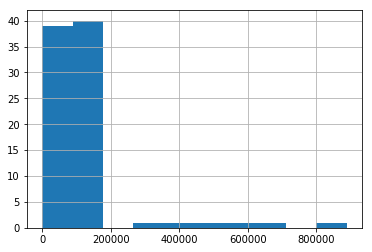

In [16]:
# Investigate patterns in the amount of missing data in each column.
miss_counts.hist()

In [12]:
# view which columns are outliers

#create dataset with the column names for those with NaNs in the original azdias dataset
miss_azdias = miss_counts.reset_index()
#
#print('The top 10 columns with the highest count of NaNs are {}'.format(miss_azdias.head(10)))
print('The top 10 columns with the highest count of NaNs are:')
print(miss_azdias.head(10))

#From the above histogram let's seperate columns with values > 300,000 as those might be the outlier columns.
filter_azdias = miss_azdias[miss_azdias[0]>300000]
#print(filter_azdias)

The top 10 columns with the highest count of NaNs are:
            index       0
0        TITEL_KZ  889061
1        AGER_TYP  685843
2    KK_KUNDENTYP  584612
3    KBA05_BAUMAX  476524
4     GEBURTSJAHR  392318
5        ALTER_HH  310267
6        REGIOTYP  158064
7             KKK  158064
8  W_KEIT_KIND_HH  147988
9     KBA05_ANTG4  133324


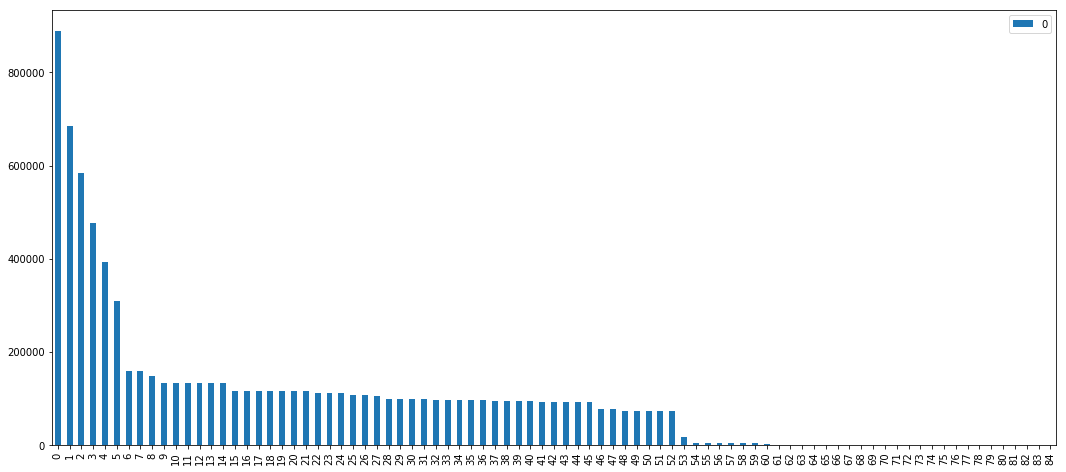

In [13]:
# plot to show the column names with respect to those values that are NaNs
#view the distribution of the column indexs for those with NaNs
miss_azdias.plot.bar(figsize=(18, 8));

In [14]:
azdias_new.shape

(891221, 85)

In [15]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)

drop_cols = ['TITEL_KZ', 'AGER_TYP', 'KK_KUNDENTYP','KBA05_BAUMAX', 'GEBURTSJAHR','ALTER_HH'] #outlier columns to be dropped

#drop columns
azdias_new.drop(drop_cols, axis=1, inplace=True)

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [16]:
# just checking the new shape of azdias_new after outlier columns have been removed
azdias_new.shape

(891221, 79)

In [17]:
# drop the outlier copies from the feat_info dataset too
feat_info_new = feat_info.copy()
feat_info_new = feat_info_new[~feat_info_new.attribute.isin(drop_cols)]

In [18]:
#check if the the outlier columns were dropped properly in feat_info_new
print(feat_info.shape)
print(feat_info_new.shape)

(85, 5)
(79, 5)


In [24]:
feat_info_new

,attribute,information_level,type,missing_or_unknown,NA_tags
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]","[-1, 0, 9]"
2,ANREDE_KZ,person,categorical,"[-1,0]","[-1, 0]"
3,CJT_GESAMTTYP,person,categorical,[0],[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1],[-1]
5,FINANZ_SPARER,person,ordinal,[-1],[-1]
6,FINANZ_VORSORGER,person,ordinal,[-1],[-1]
7,FINANZ_ANLEGER,person,ordinal,[-1],[-1]
8,FINANZ_UNAUFFAELLIGER,person,ordinal,[-1],[-1]
9,FINANZ_HAUSBAUER,person,ordinal,[-1],[-1]
10,FINANZTYP,person,categorical,[-1],[-1]


In [19]:
#calculating the proportion of the missing values for each columns 

#missing proportion dictionary
miss_prop_dic = {'Sum': miss_counts.values, 'Proportion (%)': np.round(miss_counts.values * 100 / azdias_new.shape[0], 2)}

miss_prop2 = pd.DataFrame(data=miss_prop_dic, index=miss_counts.index) # create dataframe of the results

In [20]:
# more statistics
miss_prop2.describe()

,Sum,Proportion (%)
count,85.000000,85.000000
mean,98516.811765,11.054000
std,146604.203317,16.450525
min,0.000000,0.000000
25%,0.000000,0.000000
50%,93148.000000,10.450000
75%,116515.000000,13.070000
max,889061.000000,99.760000


In [21]:
# view the result
miss_prop2 

,Sum,Proportion (%)
TITEL_KZ,889061,99.76
AGER_TYP,685843,76.96
KK_KUNDENTYP,584612,65.60
KBA05_BAUMAX,476524,53.47
GEBURTSJAHR,392318,44.02
ALTER_HH,310267,34.81
REGIOTYP,158064,17.74
KKK,158064,17.74
W_KEIT_KIND_HH,147988,16.61
KBA05_ANTG4,133324,14.96


#### Discussion 1.1.2: Assess Missing Data in Each Column

From the above, I plotted the count of NaN's for all the columns and observed that the top 6 outlier columns which I removed are the following: 
* TITEL_KZ
* AGER_TYP
* KK_KUNDENTYP
* KBA05_BAUMAX
* GEBURTSJAHR
* ALTER_HH

From the above, we can see that most of the columns contains missing values with a mean of 11%. 


#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [28]:
azdias_new.shape

(891221, 79)

In [29]:
azdias.shape

(891221, 85)

#### Creating a distribution plot to identify the threshold

In [22]:
# How much data is missing in each row of the dataset?

miss_row = azdias_new.isna().sum(axis=1)
miss_row.describe()
#miss_row

count    891221.000000
mean          5.649894
std          13.234687
min           0.000000
25%           0.000000
50%           0.000000
75%           3.000000
max          49.000000
dtype: float64

In [23]:
miss_row.head()

0    43
1     0
2     0
3     7
4     0
dtype: int64

In [24]:
# create dataset with NaN in the rows
azdias_new['na_in_rows'] = azdias_new.isna().sum(axis=1)
azdias_new.head()



/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,na_in_rows
0,2.0,1,2.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,43
1,1.0,2,5.0,1,5,2,5,4,5,1,...,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0,0
2,3.0,2,3.0,1,4,1,2,3,5,1,...,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0,0
3,4.0,2,2.0,4,2,5,2,1,2,6,...,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0,7
4,3.0,1,5.0,4,3,4,1,3,2,5,...,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0,0


In [25]:
azdias_new.shape

(891221, 80)

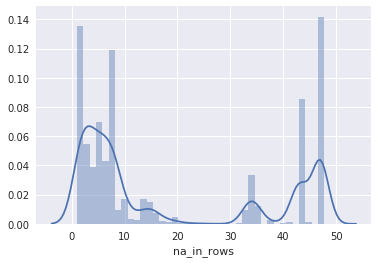

In [26]:
sns.set(style = 'darkgrid')
sns.distplot(azdias_new[azdias_new['na_in_rows']>0]['na_in_rows'])

In [27]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.

#From the distribution plot, there is a clear split of the data for those with NaN in the rows
# There are those with more missing values (around 25) and those below that
# So I will set my threshold to be 25 
above_thres = azdias_new[azdias_new['na_in_rows']>25]
below_thres = azdias_new[azdias_new['na_in_rows']<=25]

In [28]:
#view data of those with missing values for above threshold dataset
above_thres.isna().sum()

ALTERSKATEGORIE_GROB        80
ANREDE_KZ                    0
CJT_GESAMTTYP              141
FINANZ_MINIMALIST            0
FINANZ_SPARER                0
FINANZ_VORSORGER             0
FINANZ_ANLEGER               0
FINANZ_UNAUFFAELLIGER        0
FINANZ_HAUSBAUER             0
FINANZTYP                    0
GFK_URLAUBERTYP            141
GREEN_AVANTGARDE             0
HEALTH_TYP               74516
LP_LEBENSPHASE_FEIN      47499
LP_LEBENSPHASE_GROB      47325
LP_FAMILIE_FEIN          46395
LP_FAMILIE_GROB          46395
LP_STATUS_FEIN             141
LP_STATUS_GROB             141
NATIONALITAET_KZ         74436
PRAEGENDE_JUGENDJAHRE    79455
RETOURTYP_BK_S             141
SEMIO_SOZ                    0
SEMIO_FAM                    0
SEMIO_REL                    0
SEMIO_MAT                    0
SEMIO_VERT                   0
SEMIO_LUST                   0
SEMIO_ERL                    0
SEMIO_KULT                   0
                         ...  
OST_WEST_KZ              93148
WOHNLAGE

In [29]:
above_thres.isna().sum().sum()

4023787

In [30]:
#view data of those with missing values for below threshold dataset
below_thres.isna().sum()

ALTERSKATEGORIE_GROB      2801
ANREDE_KZ                    0
CJT_GESAMTTYP             4713
FINANZ_MINIMALIST            0
FINANZ_SPARER                0
FINANZ_VORSORGER             0
FINANZ_ANLEGER               0
FINANZ_UNAUFFAELLIGER        0
FINANZ_HAUSBAUER             0
FINANZTYP                    0
GFK_URLAUBERTYP           4713
GREEN_AVANTGARDE             0
HEALTH_TYP               36680
LP_LEBENSPHASE_FEIN      50133
LP_LEBENSPHASE_GROB      47247
LP_FAMILIE_FEIN          31397
LP_FAMILIE_GROB          31397
LP_STATUS_FEIN            4713
LP_STATUS_GROB            4713
NATIONALITAET_KZ         33879
PRAEGENDE_JUGENDJAHRE    28709
RETOURTYP_BK_S            4713
SEMIO_SOZ                    0
SEMIO_FAM                    0
SEMIO_REL                    0
SEMIO_MAT                    0
SEMIO_VERT                   0
SEMIO_LUST                   0
SEMIO_ERL                    0
SEMIO_KULT                   0
                         ...  
OST_WEST_KZ                  0
WOHNLAGE

In [31]:
below_thres.isna().sum().sum()

1011517

There are more missing values in above_thres that below_thres dataset

In [51]:
#check those with less or no missing values
#miss_prop2['Sum']['ZABEOTYP']
#miss_prop2['Sum']['FINANZ_VORSORGER']
#miss_prop2['Sum']['FINANZ_ANLEGER']
#miss_prop2['Sum']['SEMIO_TRADV']
miss_prop2['Sum']['GREEN_AVANTGARDE']

0

In [52]:
below_thres.shape

(797961, 80)

In [53]:
above_thres.shape

(93260, 80)

In [32]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

def dist_compare(col):
    figure(figsize=(14,3))
    
    # 1st subplot
    plt.subplot(1,2,1)
    sns.countplot(data=azdias_new.iloc[above_thres.index], x=col, color=sns.color_palette()[0])
    plt.title('Many Missing Data')
    
    # 2nd subplot
    plt.subplot(1,2,2)
    sns.countplot(data=azdias_new.iloc[below_thres.index], x=col, color=sns.color_palette()[1])
    plt.title('Few or No Missing Data')

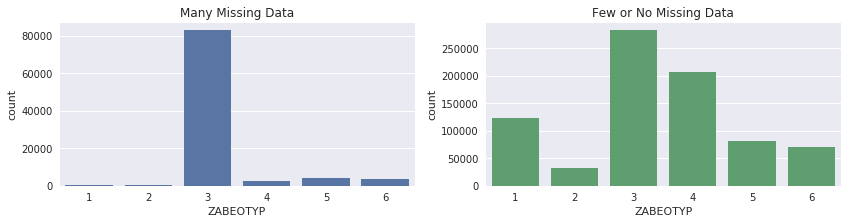

In [56]:
#compare results 1  
dist_compare('ZABEOTYP')

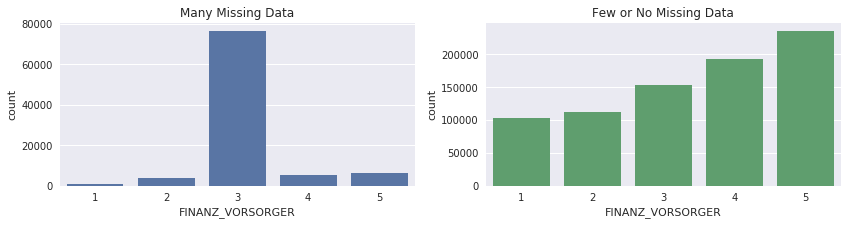

In [57]:
#compare results 2  
dist_compare('FINANZ_VORSORGER')

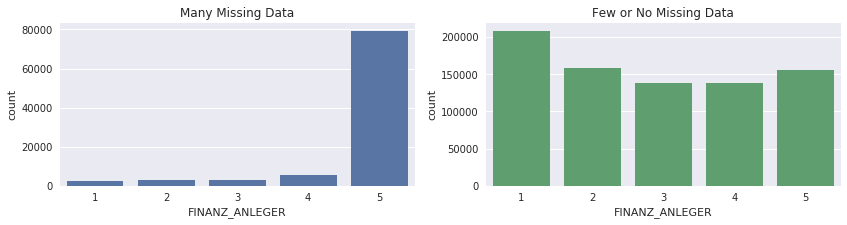

In [58]:
dist_compare('FINANZ_ANLEGER')

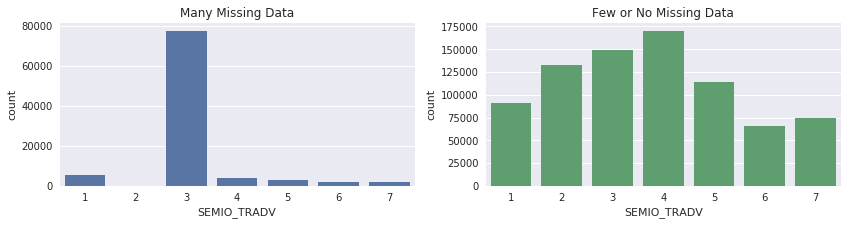

In [59]:
dist_compare('SEMIO_TRADV')

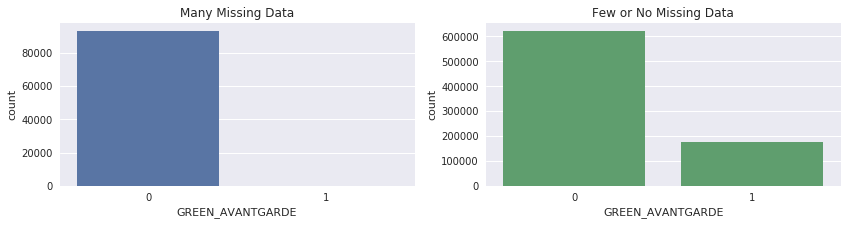

In [60]:
dist_compare('GREEN_AVANTGARDE')

#### Dropping rows with many missing values

In [61]:
#check the shape of azdias_new
azdias_new.shape

(891221, 80)

In [35]:
# select only rows with few or no missing values (drop rows with many missing values)
azdias_new2 = azdias_new.copy()
azdias_new2 = azdias_new2.iloc[below_thres.index,:]
azdias_new2.shape

(797961, 80)

#### Discussion 1.1.3: Assess Missing Data in Each Row

**Observation:**

From the 5 samples I choose, I observed that the data with lots of missing values are qualitatively different from the data with few or missing values.


### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [63]:
feat_info_new

,attribute,information_level,type,missing_or_unknown,NA_tags
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]","[-1, 0, 9]"
2,ANREDE_KZ,person,categorical,"[-1,0]","[-1, 0]"
3,CJT_GESAMTTYP,person,categorical,[0],[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1],[-1]
5,FINANZ_SPARER,person,ordinal,[-1],[-1]
6,FINANZ_VORSORGER,person,ordinal,[-1],[-1]
7,FINANZ_ANLEGER,person,ordinal,[-1],[-1]
8,FINANZ_UNAUFFAELLIGER,person,ordinal,[-1],[-1]
9,FINANZ_HAUSBAUER,person,ordinal,[-1],[-1]
10,FINANZTYP,person,categorical,[-1],[-1]


In [64]:
feat_info_new.shape

(79, 5)

In [65]:
# How many features are there of each data type?

feat_info_new.type.value_counts()

ordinal        49
categorical    18
numeric         6
mixed           6
Name: type, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [36]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?

categorical_f = feat_info_new[feat_info_new.type=='categorical']
categorical_f

,attribute,information_level,type,missing_or_unknown,NA_tags
2,ANREDE_KZ,person,categorical,"[-1,0]","[-1, 0]"
3,CJT_GESAMTTYP,person,categorical,[0],[0]
10,FINANZTYP,person,categorical,[-1],[-1]
12,GFK_URLAUBERTYP,person,categorical,[],[]
13,GREEN_AVANTGARDE,person,categorical,[],[]
17,LP_FAMILIE_FEIN,person,categorical,[0],[0]
18,LP_FAMILIE_GROB,person,categorical,[0],[0]
19,LP_STATUS_FEIN,person,categorical,[0],[0]
20,LP_STATUS_GROB,person,categorical,[0],[0]
21,NATIONALITAET_KZ,person,categorical,"[-1,0]","[-1, 0]"


In [37]:
categorical_f.shape

(18, 5)

In [68]:
azdias_new2['CAMEO_DEUG_2015'].dtype

dtype('O')

In [69]:
azdias_new2['OST_WEST_KZ'].dtype

dtype('O')

#### Re-encode categorical variable(s) to be kept in the analysis.

In [38]:
#split categorical columns into 3 parts 1. binary_num 2. binary_non_num 3. multi_level

binary_num = [] #  binary (two-level) categoricals that take numeric values
binary_non_num = [] # binary variable that takes on non-numeric values
multi_level = [] # multi-level categoricals (three or more values)

for col in categorical_f.attribute.value_counts().index:
    if len(azdias_new2[col].value_counts()) > 2:
        multi_level.append(col)
    elif azdias_new2[col].dtype==object:
        binary_non_num.append(col)
    else:
        binary_num.append(col)

In [39]:
# view what the column looks like
#binary_num
#binary_non_num
multi_level

['CJT_GESAMTTYP',
 'GEBAEUDETYP',
 'CAMEO_DEUG_2015',
 'NATIONALITAET_KZ',
 'LP_FAMILIE_GROB',
 'CAMEO_DEU_2015',
 'FINANZTYP',
 'LP_STATUS_FEIN',
 'GFK_URLAUBERTYP',
 'LP_STATUS_GROB',
 'LP_FAMILIE_FEIN',
 'ZABEOTYP',
 'SHOPPER_TYP']

In [40]:
binary_num

['ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'VERS_TYP']

In [41]:
binary_non_num

['OST_WEST_KZ']

####  Binary (two-level) categoricals that take numeric values

In [42]:
# check out what the binary numerical dataset looks like
print(azdias_new2[binary_num].head())

   ANREDE_KZ  GREEN_AVANTGARDE  SOHO_KZ  VERS_TYP
1          2                 0      1.0       2.0
2          2                 1      0.0       1.0
3          2                 0      0.0       1.0
4          1                 0      0.0       2.0
5          2                 0      0.0       2.0


In [43]:
# view the counts for each colum
for col in binary_num:
    print(azdias_new2[col].value_counts())

2    416117
1    381844
Name: ANREDE_KZ, dtype: int64
0    622741
1    175220
Name: GREEN_AVANTGARDE, dtype: int64
0.0    791245
1.0      6716
Name: SOHO_KZ, dtype: int64
2.0    394229
1.0    367052
Name: VERS_TYP, dtype: int64


In [44]:
#I will encode the ANREDE_KZ and VERS_TYP by replacing (2 with 1) and (1 with 0) so all the values match for this dataset

#make a copy of azdias_new2 to use
azdias_new3 = azdias_new2.copy()
azdias_new3['VERS_TYP'].replace([2.0, 1.0], [1, 0],inplace=True)
azdias_new3['ANREDE_KZ'].replace([2, 1], [1, 0],inplace=True)

In [45]:
#check results again to make sure the encoding worked well
for col in binary_num:
    print(azdias_new3[col].value_counts())

1    416117
0    381844
Name: ANREDE_KZ, dtype: int64
0    622741
1    175220
Name: GREEN_AVANTGARDE, dtype: int64
0.0    791245
1.0      6716
Name: SOHO_KZ, dtype: int64
1.0    394229
0.0    367052
Name: VERS_TYP, dtype: int64


#### Binary variable that takes on non-numeric values

In [46]:
# check out what the binary non-numerical dataset looks like
azdias_new3[binary_non_num].head()

,OST_WEST_KZ
1,W
2,W
3,W
4,W
5,W


In [47]:
# view the counts for the column
azdias_new3['OST_WEST_KZ'].value_counts()

W    629433
O    168528
Name: OST_WEST_KZ, dtype: int64

In [48]:
# I will encode OST_WEST_KZ from (W,O) to (1,0)
azdias_new3['OST_WEST_KZ'].replace(['W', 'O'], [1, 0],inplace=True)

In [49]:
# check results again to make sure the encoding worked well
azdias_new3['OST_WEST_KZ'].value_counts()

1    629433
0    168528
Name: OST_WEST_KZ, dtype: int64

#### Multi-level categoricals (three or more values)

In [50]:
# check out what the multi-level dataset looks like
azdias_new3[multi_level].head()

,CJT_GESAMTTYP,GEBAEUDETYP,CAMEO_DEUG_2015,NATIONALITAET_KZ,LP_FAMILIE_GROB,CAMEO_DEU_2015,FINANZTYP,LP_STATUS_FEIN,GFK_URLAUBERTYP,LP_STATUS_GROB,LP_FAMILIE_FEIN,ZABEOTYP,SHOPPER_TYP
1,5.0,8.0,8,1.0,3.0,8A,1,2.0,10.0,1.0,5.0,5,3.0
2,3.0,1.0,4,1.0,1.0,4C,1,3.0,10.0,2.0,1.0,5,2.0
3,2.0,1.0,2,1.0,NaN,2A,6,9.0,1.0,4.0,NaN,3,1.0
4,5.0,1.0,6,1.0,5.0,6B,5,3.0,5.0,2.0,10.0,4,2.0
5,2.0,1.0,8,1.0,1.0,8C,2,4.0,1.0,2.0,1.0,4,0.0


In [51]:
# view the counts for each colum
for col in multi_level:
    print(azdias_new3[col].value_counts())

4.0    198286
3.0    147208
2.0    141263
5.0    111107
6.0    102077
1.0     93307
Name: CJT_GESAMTTYP, dtype: int64
1.0    460409
3.0    178653
8.0    152472
2.0      4904
4.0       897
6.0       625
5.0         1
Name: GEBAEUDETYP, dtype: int64
8    134439
9    108176
6    105873
4    103905
3     86769
2     83226
7     77933
5     55307
1     36212
Name: CAMEO_DEUG_2015, dtype: int64
1.0    667876
2.0     63645
3.0     32561
Name: NATIONALITAET_KZ, dtype: int64
1.0    402539
5.0    188164
2.0     98551
4.0     49881
3.0     27429
Name: LP_FAMILIE_GROB, dtype: int64
6B    56672
8A    52437
4C    47816
2D    35074
3C    34766
7A    34399
3D    34304
8B    33434
4A    33152
8C    30992
9D    28593
9B    27676
9C    24987
7B    24503
9A    20542
2C    19420
8D    17576
6E    16107
2B    15484
5D    14943
6C    14820
2A    13248
5A    12211
1D    11909
1A    10850
3A    10542
5B    10354
5C     9935
7C     9065
4B     9047
4D     8570
3B     7157
6A     6809
9E     6378
6D     6073
6F 

In [52]:
azdias_new3.shape

(797961, 80)

In [53]:
azdias_new2['OST_WEST_KZ'].value_counts()

W    629433
O    168528
Name: OST_WEST_KZ, dtype: int64

In [54]:
#check to see if azdias_new3 was properly re-encoded
azdias_new3['OST_WEST_KZ'].value_counts()

1    629433
0    168528
Name: OST_WEST_KZ, dtype: int64

In [55]:
# Encode the multi-level columns using multiple dummy variables (pd.get_dummies)
azdias_new3 = pd.get_dummies(azdias_new3, columns=multi_level)
azdias_new3.shape

(797961, 195)

In [56]:
azdias_new3['CAMEO_INTL_2015'].isna().sum()

6121

In [57]:
azdias_new3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 797961 entries, 1 to 891220
Columns: 195 entries, ALTERSKATEGORIE_GROB to SHOPPER_TYP_3.0
dtypes: float64(42), int64(24), object(1), uint8(128)
memory usage: 511.4+ MB


In [58]:
feat_info_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 79 entries, 1 to 84
Data columns (total 5 columns):
attribute             79 non-null object
information_level     79 non-null object
type                  79 non-null object
missing_or_unknown    79 non-null object
NA_tags               79 non-null object
dtypes: object(5)
memory usage: 3.7+ KB


#### Discussion 1.2.1: Re-Encode Categorical Features

**1. Binary (two-level) categoricals that take numeric values:** I re-encoded VERS_TYP and ANREDE_KZ from (2,1) to (1,0) for consistency between the other variables.

**2. Binary variable that takes on non-numeric values:** I re-encoded OST_WEST_KZ from (W,O) to (1,0)

**3. Multi-level categoricals (three or more values):** I encoded about 13 of them (as shown above for multi_level data) using the `pd.get_dummies` function and did not drop them as it might be useful in the clustering part.


#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [91]:
feat_info_new.shape

(79, 5)

In [60]:
# view the mixed type features
mixed_type = feat_info_new[feat_info_new.type=='mixed']
mixed_type

,attribute,information_level,type,missing_or_unknown,NA_tags
15,LP_LEBENSPHASE_FEIN,person,mixed,[0],[0]
16,LP_LEBENSPHASE_GROB,person,mixed,[0],[0]
22,PRAEGENDE_JUGENDJAHRE,person,mixed,"[-1,0]","[-1, 0]"
56,WOHNLAGE,building,mixed,[-1],[-1]
59,CAMEO_INTL_2015,microcell_rr4,mixed,"[-1,XX]","[-1, XX]"
79,PLZ8_BAUMAX,macrocell_plz8,mixed,"[-1,0]","[-1, 0]"


In [61]:
mixed_type.shape

(6, 5)

In [94]:
feat_info_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 79 entries, 1 to 84
Data columns (total 5 columns):
attribute             79 non-null object
information_level     79 non-null object
type                  79 non-null object
missing_or_unknown    79 non-null object
NA_tags               79 non-null object
dtypes: object(5)
memory usage: 3.7+ KB


In [95]:
azdias_new3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 797961 entries, 1 to 891220
Columns: 195 entries, ALTERSKATEGORIE_GROB to GFK_URLAUBERTYP_12.0
dtypes: float64(42), int64(24), object(1), uint8(128)
memory usage: 511.4+ MB


#### Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.

PRAEGENDE_JUGENDJAHRE mapping from Data_Dictionary.md

Dominating movement of person's youth (avantgarde vs. mainstream; east vs. west)
- -1: unknown
-  0: unknown
-  1: 40s - war years (Mainstream, E+W)
-  2: 40s - reconstruction years (Avantgarde, E+W)
-  3: 50s - economic miracle (Mainstream, E+W)
-  4: 50s - milk bar / Individualisation (Avantgarde, E+W)
-  5: 60s - economic miracle (Mainstream, E+W)
-  6: 60s - generation 68 / student protestors (Avantgarde, W)
-  7: 60s - opponents to the building of the Wall (Avantgarde, E)
-  8: 70s - family orientation (Mainstream, E+W)
-  9: 70s - peace movement (Avantgarde, E+W)
- 10: 80s - Generation Golf (Mainstream, W)
- 11: 80s - ecological awareness (Avantgarde, W)
- 12: 80s - FDJ / communist party youth organisation (Mainstream, E)
- 13: 80s - Swords into ploughshares (Avantgarde, E)
- 14: 90s - digital media kids (Mainstream, E+W)
- 15: 90s - ecological awareness (Avantgarde, E+W)

In [62]:
#view the values in PRAEGENDE_JUGENDJAHRE
azdias_new3['PRAEGENDE_JUGENDJAHRE'].value_counts()

14.0    182968
8.0     141612
10.0     85800
5.0      84687
3.0      53841
15.0     42543
11.0     35751
9.0      33570
6.0      25652
12.0     24446
1.0      20678
4.0      20451
2.0       7479
13.0      5764
7.0       4010
Name: PRAEGENDE_JUGENDJAHRE, dtype: int64

In [63]:
# generation by decade (capture an interval-type variable for decade)
gen = {0: [1, 2], #40's
      1: [3, 4], #50's
      2: [5, 6, 7], #60's
      3: [8, 9], # 70s
      4: [10, 11, 12, 13], #80's
      5:[14, 15]} #90's

# Function to caputure generations
def generation(val):
    if np.isnan(val):
        return np.nan
    else:
        for key,value in gen.items():
            if val in value:
                return key

In [64]:
# movement (mainstream vs. avantgarde) (capture a binary variable for movement.)
avantgarde = [2, 4, 6, 7, 9, 11, 13, 15]
mainstream = [1, 3, 5, 8, 10, 12, 14]

#function to capture movement
def move(val):
    if val in avantgarde:
        return 1
    elif val in mainstream:
        return 0
    else:
        return np.nan      

In [65]:
# Engineering generation
azdias_new3['PRAEGENDE_JUGENDJAHRE_gen']=azdias_new3['PRAEGENDE_JUGENDJAHRE'].apply(generation)

In [66]:
# Engineering movement
azdias_new3['PRAEGENDE_JUGENDJAHRE_mov']=azdias_new3['PRAEGENDE_JUGENDJAHRE'].apply(move)

#### Investigate "CAMEO_INTL_2015" and engineer two new variables.

CAMEO_INTL_2015 mapping from Data_Dictionary.md

German CAMEO: Wealth / Life Stage Typology, mapped to international code
- -1: unknown
- 11: Wealthy Households - Pre-Family Couples & Singles
- 12: Wealthy Households - Young Couples With Children
- 13: Wealthy Households - Families With School Age Children
- 14: Wealthy Households - Older Families &  Mature Couples
- 15: Wealthy Households - Elders In Retirement
- 21: Prosperous Households - Pre-Family Couples & Singles
- 22: Prosperous Households - Young Couples With Children
- 23: Prosperous Households - Families With School Age Children
- 24: Prosperous Households - Older Families & Mature Couples
- 25: Prosperous Households - Elders In Retirement
- 31: Comfortable Households - Pre-Family Couples & Singles
- 32: Comfortable Households - Young Couples With Children
- 33: Comfortable Households - Families With School Age Children
- 34: Comfortable Households - Older Families & Mature Couples
- 35: Comfortable Households - Elders In Retirement
- 41: Less Affluent Households - Pre-Family Couples & Singles
- 42: Less Affluent Households - Young Couples With Children
- 43: Less Affluent Households - Families With School Age Children
- 44: Less Affluent Households - Older Families & Mature Couples
- 45: Less Affluent Households - Elders In Retirement
- 51: Poorer Households - Pre-Family Couples & Singles
- 52: Poorer Households - Young Couples With Children
- 53: Poorer Households - Families With School Age Children
- 54: Poorer Households - Older Families & Mature Couples
- 55: Poorer Households - Elders In Retirement
- XX: unknown

In [67]:
#view the values in CAMEO_INTL_2015
azdias_new3['CAMEO_INTL_2015'].value_counts()

51    133693
41     92336
24     91152
14     62882
43     56672
54     45390
25     39624
22     33152
23     26746
13     26334
45     26132
55     23954
52     20542
31     19020
34     18524
15     16974
44     14820
12     13248
35     10356
32     10354
33      9935
Name: CAMEO_INTL_2015, dtype: int64

In [68]:
# view the type
azdias_new3['CAMEO_INTL_2015'].dtype

dtype('O')

In [69]:
#"CAMEO_INTL_2015" combines information on two axes: wealth and life stage. 
# Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables 
#(which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).

In [70]:
# Make life stage the ones's place
def life(val):
    val = float(val)
    if np.isnan(val):
    #if pd.isnull(val):
        return np.nan
    else:
        return int(str(val)[1])

In [71]:
# Make wealth the ten's place

def wealth(val):
    val = float(val)
    if np.isnan(val):
    #if pd.isnull(val):
        return np.nan
    else:
        return int(str(val)[0])

In [72]:
# Engineering Wealth
azdias_new3['CAMEO_INTL_2015_wealth']=azdias_new3['CAMEO_INTL_2015'].apply(wealth)

In [73]:
# Engineering Life stage
azdias_new3['CAMEO_INTL_2015_life_stage']=azdias_new3['CAMEO_INTL_2015'].apply(life)

In [62]:
azdias_new3.T

,1,2,3,4,5,6,7,8,9,10,...,891211,891212,891213,891214,891215,891216,891217,891218,891219,891220
ALTERSKATEGORIE_GROB,1,3,4,3,1,2,1,3,3,3,...,3,4,4,1,2,3,2,2,1,4
ANREDE_KZ,1,1,1,0,1,1,0,0,1,1,...,0,0,1,1,1,1,0,1,0,0
FINANZ_MINIMALIST,1,1,4,4,3,1,3,4,2,2,...,3,3,3,1,1,1,3,2,1,4
FINANZ_SPARER,5,4,2,3,1,5,3,4,4,2,...,2,1,3,5,5,4,3,4,5,2
FINANZ_VORSORGER,2,1,5,4,5,1,4,2,2,5,...,4,5,3,2,2,2,3,2,3,5
FINANZ_ANLEGER,5,2,2,1,2,5,1,4,3,3,...,3,1,5,3,4,5,2,5,5,2
FINANZ_UNAUFFAELLIGER,4,3,1,3,2,4,3,2,5,1,...,3,1,3,3,5,4,2,4,5,1
FINANZ_HAUSBAUER,5,5,2,2,5,3,2,2,4,5,...,2,5,2,4,4,4,3,3,5,5
GREEN_AVANTGARDE,0,1,0,0,0,0,0,1,1,0,...,0,0,1,0,0,0,0,0,0,0
HEALTH_TYP,3,3,2,3,3,2,1,3,2,2,...,3,1,1,3,2,3,NaN,1,1,2


In [107]:
azdias_new3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 797961 entries, 1 to 891220
Columns: 199 entries, ALTERSKATEGORIE_GROB to CAMEO_INTL_2015_life_stage
dtypes: float64(46), int64(24), object(1), uint8(128)
memory usage: 535.7+ MB


In [108]:
azdias_new3.shape

(797961, 199)

In [74]:
# viewing the mixed type attributes
mixed_type.attribute

15      LP_LEBENSPHASE_FEIN
16      LP_LEBENSPHASE_GROB
22    PRAEGENDE_JUGENDJAHRE
56                 WOHNLAGE
59          CAMEO_INTL_2015
79              PLZ8_BAUMAX
Name: attribute, dtype: object

In [75]:
# droping mixed features except the encoded ones
azdias_new3 = azdias_new3.drop(columns=mixed_type.attribute.values)

In [76]:
# check counts of missing number after dropping off mixed features
#azdias_new3.isna().sum().value_counts()
missing_num_left = azdias_new3.isna().sum(axis=1)
missing_num_left

1          0
2          0
3          3
4          0
5          0
6          0
7          0
8          0
9          0
10         0
12         6
13         8
15         7
16         2
18         3
19         0
20         9
21         0
22         0
23         7
25         1
26        17
27         0
28         0
29         2
31         0
32         0
33         0
34         2
36         0
          ..
891191     0
891192     0
891193     0
891194     0
891195     0
891196     0
891197     0
891198     0
891199     0
891200     0
891201     0
891202     0
891203    11
891204     0
891205     0
891206     0
891207     0
891208     3
891209     0
891210     0
891211     0
891212     0
891213     0
891214     0
891215     0
891216     3
891217     2
891218     1
891219     0
891220     0
Length: 797961, dtype: int64

In [77]:
# view missing number count
azdias_new3.isna().sum()

ALTERSKATEGORIE_GROB           2801
ANREDE_KZ                         0
FINANZ_MINIMALIST                 0
FINANZ_SPARER                     0
FINANZ_VORSORGER                  0
FINANZ_ANLEGER                    0
FINANZ_UNAUFFAELLIGER             0
FINANZ_HAUSBAUER                  0
GREEN_AVANTGARDE                  0
HEALTH_TYP                    36680
RETOURTYP_BK_S                 4713
SEMIO_SOZ                         0
SEMIO_FAM                         0
SEMIO_REL                         0
SEMIO_MAT                         0
SEMIO_VERT                        0
SEMIO_LUST                        0
SEMIO_ERL                         0
SEMIO_KULT                        0
SEMIO_RAT                         0
SEMIO_KRIT                        0
SEMIO_DOM                         0
SEMIO_KAEM                        0
SEMIO_PFLICHT                     0
SEMIO_TRADV                       0
SOHO_KZ                           0
VERS_TYP                      36680
ANZ_PERSONEN                

In [78]:
# view azdias_new3 after droping the mixed type feature
azdias_new3.shape

(797961, 193)

In [79]:
#verify the dropped mixed features
azdias_new3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 797961 entries, 1 to 891220
Columns: 193 entries, ALTERSKATEGORIE_GROB to CAMEO_INTL_2015_life_stage
dtypes: float64(41), int64(24), uint8(128)
memory usage: 499.2 MB


In [80]:
# count number of columns in azdias_new3
len(azdias_new3.columns) 

193

In [81]:
#unique values present in each column  
unique_c = []
for i in azdias_new3.columns:
    unique_c.append(
        {'Feature': i,
         'Unique Counts': azdias_new3[i].unique()}
    )
pd.DataFrame(unique_c)    

,Feature,Unique Counts
0,ALTERSKATEGORIE_GROB,"[1.0, 3.0, 4.0, 2.0, nan]"
1,ANREDE_KZ,"[1, 0]"
2,FINANZ_MINIMALIST,"[1, 4, 3, 2, 5]"
3,FINANZ_SPARER,"[5, 4, 2, 3, 1]"
4,FINANZ_VORSORGER,"[2, 1, 5, 4, 3]"
5,FINANZ_ANLEGER,"[5, 2, 1, 4, 3]"
6,FINANZ_UNAUFFAELLIGER,"[4, 3, 1, 2, 5]"
7,FINANZ_HAUSBAUER,"[5, 2, 3, 4, 1]"
8,GREEN_AVANTGARDE,"[0, 1]"
9,HEALTH_TYP,"[3.0, 2.0, 1.0, nan]"


In [82]:
print(feat_info_new.shape)
feat_info_new.head()

(79, 5)


,attribute,information_level,type,missing_or_unknown,NA_tags
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]","[-1, 0, 9]"
2,ANREDE_KZ,person,categorical,"[-1,0]","[-1, 0]"
3,CJT_GESAMTTYP,person,categorical,[0],[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1],[-1]
5,FINANZ_SPARER,person,ordinal,[-1],[-1]


#### Discussion 1.2.2: Engineer Mixed-Type Features

1. I engineered the `PRAEGENDE_JUGENDJAHRE` variable by converting it into two binary variables i.e. generation and movement.
2. I also engineered the `CAMEO_INTL_2015` variable by converting it into two ordinal variables  i.e. wealth and life stage.
3. I decided to drop all the mixed type features for simplicity of this project, but also given the fact that it might require a deeper understanding of these columns to perform an appropriate re-engineering.

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [118]:
feat_info_new.type.value_counts()

ordinal        49
categorical    18
numeric         6
mixed           6
Name: type, dtype: int64

In [ ]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)

#azdias_new3.T

In [ ]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [83]:
def clean_data(azdias, feat_info):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    
    # Apply the strings_2_list function
    feat_info['NA_tags'] = feat_info['missing_or_unknown'].apply(string_2_list)
    
    att_index = feat_info.set_index('attribute')

    # copy of the demographics data to work with to be the version with NA's inserted
    azdias_new = azdias[:]

    # For every column in the data, if the value is in Na_tags list, replace it inplace with np.NaN
    for column in azdias_new.columns:
        azdias_new[column].replace(att_index.loc[column].loc['NA_tags'],np.NaN,inplace=True)
    
    # remove selected columns and rows, ...
    drop_cols = ['TITEL_KZ', 'AGER_TYP', 'KK_KUNDENTYP','KBA05_BAUMAX', 'GEBURTSJAHR','ALTER_HH']#outlier columns to drop

    #drop columns
    azdias_new.drop(drop_cols, axis=1, inplace=True)
    
    # drop the outlier copies from the feat_info dataset too
    feat_info_new = feat_info.copy()
    feat_info_new = feat_info_new[~feat_info_new.attribute.isin(drop_cols)]
    
    # Write code to divide the data into two subsets based on the number of missing
    # values in each row.
    
    #miss_row = azdias_new.isna().sum(axis=1)
    azdias_new['na_in_rows'] = azdias_new.isna().sum(axis=1)

    # I will set the threshold to be 25
    #above_thres = miss_row[miss_row > 25]
    #below_thres = miss_row[miss_row <= 25]
    
    above_thres = azdias_new[azdias_new['na_in_rows']>25]
    below_thres = azdias_new[azdias_new['na_in_rows']<=25]
    
    # drop rows with high missing values
    azdias_new2 = azdias_new.copy()
    azdias_new2 = azdias_new2.iloc[below_thres.index,:]

    
    # select, re-encode, and engineer column values.
    
    # Assess categorical variables: which are binary, which are multi-level, and
    # which one needs to be re-encoded?

    categorical_f = feat_info_new[feat_info_new.type=='categorical']
    
    #split categorical columns into 3 parts 1. binary_num 2. binary_non_num 3. multi_level

    binary_num = [] #  binary (two-level) categoricals that take numeric values
    binary_non_num = [] # binary variable that takes on non-numeric values
    multi_level = [] # multi-level categoricals (three or more values)

    for col in categorical_f.attribute.value_counts().index:
        if len(azdias_new2[col].value_counts()) > 2:
            multi_level.append(col)
        elif (azdias_new2[col].dtype==object):
            binary_non_num.append(col)
        else:
            binary_num.append(col)
            
    # I will encode the ANREDE_KZ and VERS_TYP by replace (2 with 1) and (1 with 0) so that all the values match for this dataset
    #make a copy of azdias_new2 to use
    azdias_new3 = azdias_new2.copy()
    azdias_new3['VERS_TYP'].replace([2.0, 1.0], [1, 0],inplace=True)
    azdias_new3['ANREDE_KZ'].replace([2, 1], [1, 0],inplace=True)  
    
    # I will encode OST_WEST_KZ from (W,O) to (1,0)
    azdias_new3['OST_WEST_KZ'].replace(['W', 'O'], [1, 0],inplace=True)
    
    # Encode the multi-level columns using multiple dummy variables (pd.get_dummies)
    azdias_new3 = pd.get_dummies(azdias_new3, columns=multi_level)
    
    # Engineering PRAEGENDE_JUGENDJAHRE to two new binary variables
    # Engineering generation
    azdias_new3['PRAEGENDE_JUGENDJAHRE_gen']=azdias_new3['PRAEGENDE_JUGENDJAHRE'].apply(generation)
    # Engineering movement
    azdias_new3['PRAEGENDE_JUGENDJAHRE_mov']=azdias_new3['PRAEGENDE_JUGENDJAHRE'].apply(move)
    
     # Engineering CAMEO_INTL_2015 to two new ordinal variables
    # Engineering Wealth
    azdias_new3['CAMEO_INTL_2015_wealth']=azdias_new3['CAMEO_INTL_2015'].apply(wealth)
    # Engineering Life stage
    azdias_new3['CAMEO_INTL_2015_life_stage']=azdias_new3['CAMEO_INTL_2015'].apply(life)
    
    # droping mixed features
    mixed_type = feat_info_new[feat_info_new.type=='mixed']
    azdias_new3 = azdias_new3.drop(columns=mixed_type.attribute.values)
    
    # Return the cleaned dataframe.
    return azdias_new3
    

In [84]:
mixed_type

,attribute,information_level,type,missing_or_unknown,NA_tags
15,LP_LEBENSPHASE_FEIN,person,mixed,[0],[0]
16,LP_LEBENSPHASE_GROB,person,mixed,[0],[0]
22,PRAEGENDE_JUGENDJAHRE,person,mixed,"[-1,0]","[-1, 0]"
56,WOHNLAGE,building,mixed,[-1],[-1]
59,CAMEO_INTL_2015,microcell_rr4,mixed,"[-1,XX]","[-1, XX]"
79,PLZ8_BAUMAX,macrocell_plz8,mixed,"[-1,0]","[-1, 0]"


In [85]:
# testing the clean_data function
test = azdias[:]
test_azdias = clean_data(test, feat_info)

/opt/conda/lib/python3.6/site-packages/pandas/core/generic.py:5890: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [86]:
# checking if the clean_data function works properly.
# My cleaned azdias_new3 should be the same as test_azdias

azdias_new3.equals(test_azdias)

True

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](https://scikit-learn.org/0.16/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [87]:
# view total number of missing values
azdias_new3.isnull().sum().sum()

761265

In [88]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.
azdias_new3.isna().any().values

array([ True, False, False, False, False, False, False, False, False,
        True,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False,  True,
       False, False, False,  True, False,  True,  True,  True, False,
       False,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

In [89]:
# There are still missing values, I will use an Imputer to handle them as in 
# https://scikit-learn.org/0.16/modules/generated/sklearn.preprocessing.Imputer.html

replace_miss = Imputer(missing_values = np.nan, strategy='mean', axis=1) #impute missing values with the mean
clean_azdias = pd.DataFrame(replace_miss.fit_transform(azdias_new3), columns = azdias_new3.keys())

In [90]:
# double check if there are still missing values
clean_azdias.isnull().sum()

ALTERSKATEGORIE_GROB          0
ANREDE_KZ                     0
FINANZ_MINIMALIST             0
FINANZ_SPARER                 0
FINANZ_VORSORGER              0
FINANZ_ANLEGER                0
FINANZ_UNAUFFAELLIGER         0
FINANZ_HAUSBAUER              0
GREEN_AVANTGARDE              0
HEALTH_TYP                    0
RETOURTYP_BK_S                0
SEMIO_SOZ                     0
SEMIO_FAM                     0
SEMIO_REL                     0
SEMIO_MAT                     0
SEMIO_VERT                    0
SEMIO_LUST                    0
SEMIO_ERL                     0
SEMIO_KULT                    0
SEMIO_RAT                     0
SEMIO_KRIT                    0
SEMIO_DOM                     0
SEMIO_KAEM                    0
SEMIO_PFLICHT                 0
SEMIO_TRADV                   0
SOHO_KZ                       0
VERS_TYP                      0
ANZ_PERSONEN                  0
ANZ_TITEL                     0
HH_EINKOMMEN_SCORE            0
                             ..
LP_STATU

In [91]:
clean_azdias.isna().any().values

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

In [92]:
# The dataset is now properly clean with no missing values

# view shape of the cleaned dataset
clean_azdias.shape

(797961, 193)

In [93]:
clean_azdias.columns

Index(['ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'FINANZ_MINIMALIST',
       'FINANZ_SPARER', 'FINANZ_VORSORGER', 'FINANZ_ANLEGER',
       'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER', 'GREEN_AVANTGARDE',
       'HEALTH_TYP',
       ...
       'ZABEOTYP_5', 'ZABEOTYP_6', 'SHOPPER_TYP_0.0', 'SHOPPER_TYP_1.0',
       'SHOPPER_TYP_2.0', 'SHOPPER_TYP_3.0', 'PRAEGENDE_JUGENDJAHRE_gen',
       'PRAEGENDE_JUGENDJAHRE_mov', 'CAMEO_INTL_2015_wealth',
       'CAMEO_INTL_2015_life_stage'],
      dtype='object', length=193)

In [94]:
clean_azdias['GFK_URLAUBERTYP_8.0']

0         0.0
1         0.0
2         0.0
3         0.0
4         0.0
5         0.0
6         0.0
7         0.0
8         0.0
9         1.0
10        0.0
11        0.0
12        0.0
13        0.0
14        0.0
15        1.0
16        0.0
17        0.0
18        0.0
19        0.0
20        0.0
21        0.0
22        1.0
23        0.0
24        0.0
25        0.0
26        0.0
27        0.0
28        0.0
29        0.0
         ... 
797931    0.0
797932    0.0
797933    0.0
797934    0.0
797935    0.0
797936    0.0
797937    0.0
797938    0.0
797939    0.0
797940    0.0
797941    0.0
797942    0.0
797943    1.0
797944    0.0
797945    0.0
797946    0.0
797947    1.0
797948    0.0
797949    0.0
797950    0.0
797951    0.0
797952    0.0
797953    1.0
797954    0.0
797955    0.0
797956    0.0
797957    0.0
797958    0.0
797959    0.0
797960    0.0
Name: GFK_URLAUBERTYP_8.0, Length: 797961, dtype: float64

In [95]:
clean_azdias['na_in_rows']

0          0.0
1          0.0
2          7.0
3          0.0
4          0.0
5          0.0
6          0.0
7          0.0
8          0.0
9          0.0
10         6.0
11         8.0
12         8.0
13         6.0
14         3.0
15         0.0
16        10.0
17         0.0
18         0.0
19         8.0
20         5.0
21        19.0
22         0.0
23         0.0
24         2.0
25         0.0
26         0.0
27         0.0
28         4.0
29         0.0
          ... 
797931     0.0
797932     0.0
797933     0.0
797934     0.0
797935     0.0
797936     0.0
797937     0.0
797938     0.0
797939     0.0
797940     0.0
797941     0.0
797942     0.0
797943    14.0
797944     0.0
797945     0.0
797946     0.0
797947     0.0
797948     3.0
797949     0.0
797950     0.0
797951     0.0
797952     0.0
797953     0.0
797954     0.0
797955     0.0
797956     3.0
797957     4.0
797958     5.0
797959     0.0
797960     0.0
Name: na_in_rows, Length: 797961, dtype: float64

In [96]:
# Apply feature scaling to the general population demographics data.

feature_scale = StandardScaler() #feature scaling initialization
azdias_feature_scale = pd.DataFrame(feature_scale.fit_transform(clean_azdias), columns=clean_azdias.keys())

In [97]:
azdias_feature_scale.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,ZABEOTYP_5,ZABEOTYP_6,SHOPPER_TYP_0.0,SHOPPER_TYP_1.0,SHOPPER_TYP_2.0,SHOPPER_TYP_3.0,PRAEGENDE_JUGENDJAHRE_gen,PRAEGENDE_JUGENDJAHRE_mov,CAMEO_INTL_2015_wealth,CAMEO_INTL_2015_life_stage
0,-1.471878,0.957933,-1.494605,1.537983,-1.040689,1.466048,0.958818,1.339234,-0.530442,0.079263,...,2.976005,-0.312186,-0.435315,-0.670331,-0.589775,1.847335,0.483541,-0.271741,0.963423,-1.113037
1,0.129745,0.957933,-1.494605,0.864617,-1.766963,-0.570958,0.244259,1.339234,1.885219,0.079263,...,2.976005,-0.312186,-0.435315,-0.670331,1.695563,-0.541320,0.483541,0.089455,-0.779089,0.594780
2,0.930556,0.957933,0.683156,-0.482116,1.138133,-0.570958,-1.184858,-0.791347,-0.530442,-0.281221,...,-0.336021,-0.312186,-0.435315,1.491800,-0.589775,-0.541320,-0.286955,-0.271741,-1.359926,-0.543765
3,0.129745,-1.043914,0.683156,0.191250,0.411859,-1.249960,0.244259,-0.791347,-0.530442,0.079263,...,-0.336021,-0.312186,-0.435315,-0.670331,1.695563,-0.541320,-0.286955,-0.271741,0.382586,0.025507
4,-1.471878,0.957933,-0.042764,-1.155482,1.138133,-0.570958,-0.470299,1.339234,-0.530442,0.079263,...,-0.336021,-0.312186,2.297189,-0.670331,-0.589775,-0.541320,-1.057450,-0.271741,0.963423,0.594780


### Discussion 2.1: Apply Feature Scaling

1. I handled the remaining missing values in my dataset by imputing them with the mean of their respective columns.
2. I used the StandardScaler instance to scale my features as it scales each feature with a mean of 0 and a standard deviation of 1.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [98]:
# Apply PCA to the data.

pca_inst = PCA() # pca instance
pca_azdias = pca_inst.fit_transform(azdias_feature_scale)

In [99]:
pca_azdias

array([[ -4.91782436e+00,   2.61946480e+00,  -2.86810969e-01, ...,
         -2.46929928e-14,   5.42752017e-15,  -3.26582358e-17],
       [ -7.83642325e-01,  -4.33792564e-01,   6.51529115e-01, ...,
          4.74277774e-14,   2.15434656e-14,   9.91203148e-17],
       [  4.64781992e+00,  -1.18849159e+00,   6.22026165e-01, ...,
          8.76738061e-15,  -3.77635116e-15,  -4.05265566e-18],
       ..., 
       [ -9.17774238e-01,   2.48487810e+00,  -1.10767008e+00, ...,
         -4.82085576e-16,  -7.67717843e-17,  -2.19905091e-17],
       [ -5.76163172e+00,   3.47442575e+00,  -2.68288357e+00, ...,
          4.08270409e-17,   8.65648338e-17,   7.91792037e-18],
       [ -5.09192313e-01,  -2.28302505e+00,   1.60999673e-02, ...,
         -3.14335716e-17,   8.07451607e-17,   2.74382498e-18]])

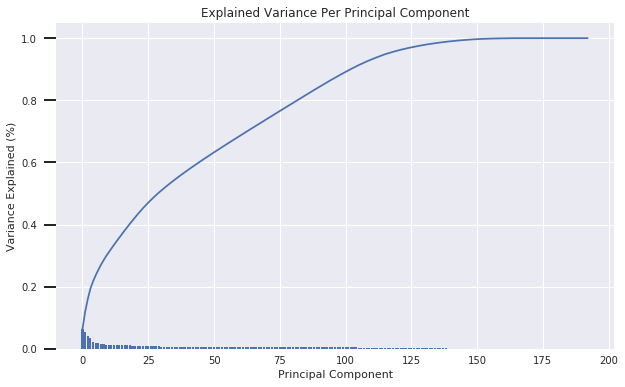

In [100]:
# Investigate the variance accounted for by each principal component.

# I will be using the scree_plot function from helper_functions.py from the lessons

def scree_plot(pca,num_components):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    '''
    num_components=len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(10, 6))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    #for i in range(num_components):
    #    ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=12)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')
    
    
scree_plot(pca_inst, num_components=None)

#### Check out the ratio of variance explained by each principal component as well as the cumulative variance explained

In [101]:
# I will try different number of principal components to see how much variability it would explain

for i in np.arange(30, len(pca_inst.explained_variance_ratio_), 30):
    print('{:.2f}% of variability is explained by {} principal components'.format(pca_inst.explained_variance_ratio_[:i].sum() * 100, i))

50.28% of variability is explained by 30 principal components
68.13% of variability is explained by 60 principal components
83.81% of variability is explained by 90 principal components
95.84% of variability is explained by 120 principal components
99.64% of variability is explained by 150 principal components
100.00% of variability is explained by 180 principal components


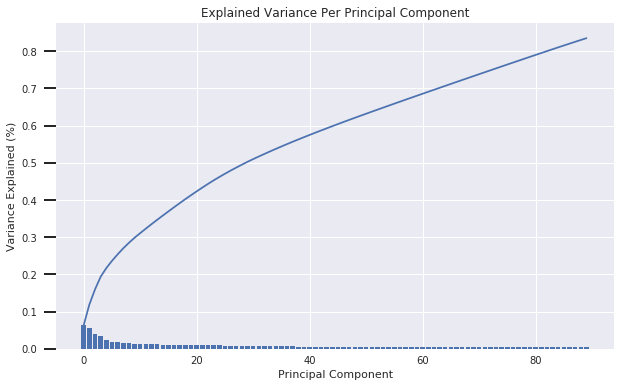

In [102]:
# Re-apply PCA to the data while selecting for number of components to retain.

#From the above, we can see that 83.8% of variability is explained by 90 principal components.
# I will be using num_components = 90 here

pca_inst = PCA(n_components=90) # pca instance
pca_azdias = pca_inst.fit_transform(azdias_feature_scale)

#view the variance explained plot with the above changes
scree_plot(pca_inst, num_components=90)

In [103]:
azdias_new3.shape

(797961, 193)

### Discussion 2.2: Perform Dimensionality Reduction

I decided to retain 90 principal components which explains about 83.8% variability of the data and a dimensional reduction from 193 to 90. I think 90 out of 193 components should be good enough to capture the most relevant information needed from the data.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [104]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

# I am using the pca_results function from helper_function.py from the lessons with modifications
def pca_results(data, pca, num_components, num_features):
    '''
    Create a DataFrame of the PCA results
    Visualizes the PCA results
    '''
    
    # PCA components
    # map each weight to their corresponding feature name
    components = pd.DataFrame(np.round(pca.components_, 4), columns = data.keys()).iloc[num_components-1]
    #components = pd.DataFrame(np.round(pca.components_, 4), columns = list(data.columns))
    
    # sort the features according to weight
    components.sort_values(ascending=False, inplace=True)
    
    #interesting features for each principal component, are those at the beginning and end of the sorted list
    components = pd.concat([components.head(num_features), components.tail(num_features)])
    
    # Create a bar plot visualization
    fig, ax = plt.subplots(figsize = (14,8))

    # Plot the feature weights as a function of the components
    components.plot(ax = ax, kind = 'bar');
    ax.set_ylabel("Feature Weights")
    #ax.set_xticklabels(dimensions, rotation=0)
    plt.show()
    
    return components

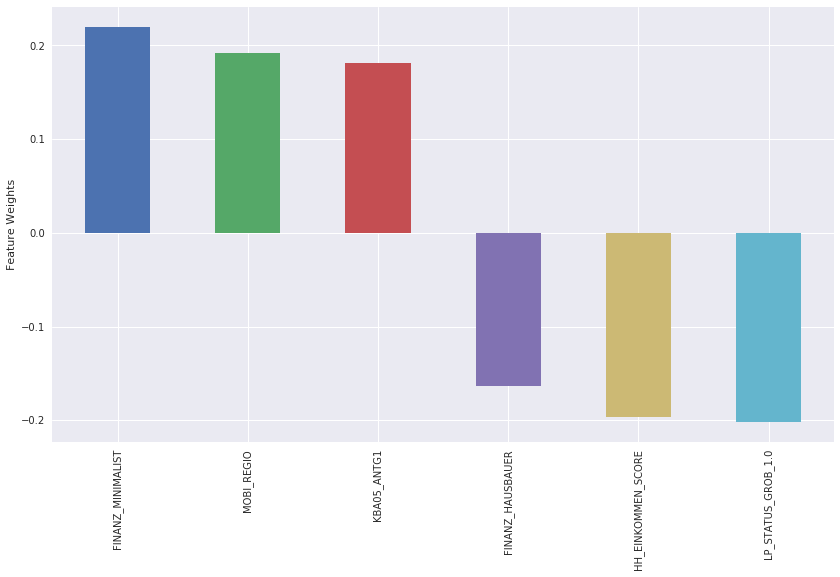

FINANZ_MINIMALIST     0.2199
MOBI_REGIO            0.1918
KBA05_ANTG1           0.1811
FINANZ_HAUSBAUER     -0.1639
HH_EINKOMMEN_SCORE   -0.1967
LP_STATUS_GROB_1.0   -0.2020
Name: 0, dtype: float64

In [105]:
# Map weights for the first principal component to corresponding feature names for the first 3 features
pca_results(clean_azdias,pca_inst,1,3)

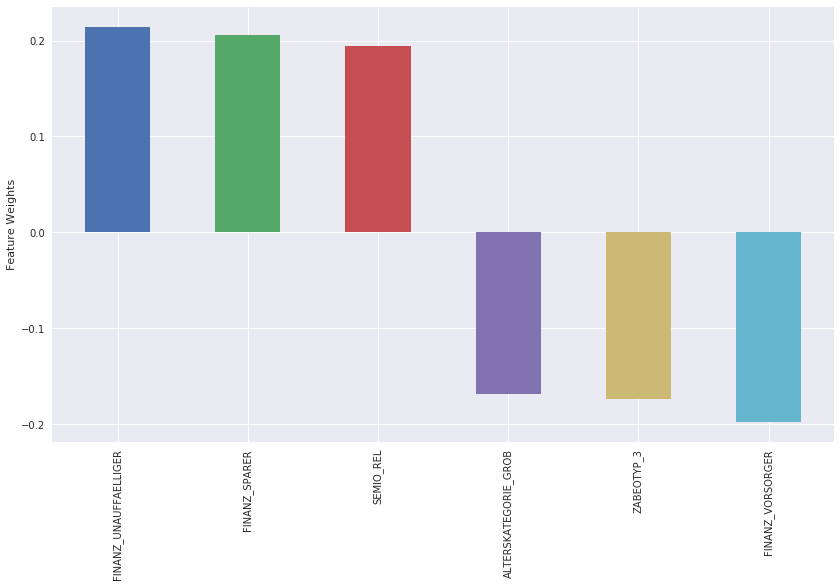

FINANZ_UNAUFFAELLIGER    0.2143
FINANZ_SPARER            0.2057
SEMIO_REL                0.1941
ALTERSKATEGORIE_GROB    -0.1682
ZABEOTYP_3              -0.1731
FINANZ_VORSORGER        -0.1977
Name: 1, dtype: float64

In [106]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.

pca_results(clean_azdias,pca_inst,2,3)

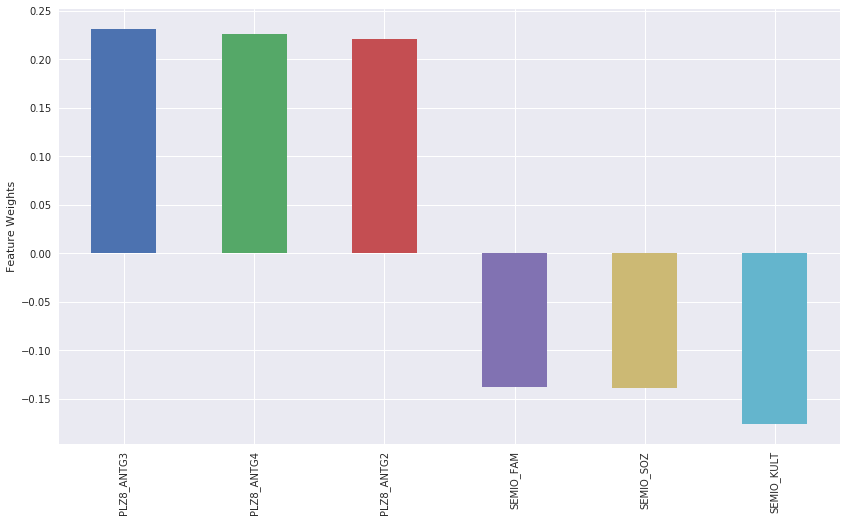

PLZ8_ANTG3    0.2316
PLZ8_ANTG4    0.2265
PLZ8_ANTG2    0.2205
SEMIO_FAM    -0.1378
SEMIO_SOZ    -0.1389
SEMIO_KULT   -0.1760
Name: 2, dtype: float64

In [107]:
# Map weights for the third principal component to corresponding feature names for the first 3 features
# and then print the linked values, sorted by weight.

pca_results(clean_azdias,pca_inst,3,3)

### Discussion 2.3: Interpret Principal Components

**Observations**

Features are said to be directly proportional to the principal components if they have positive values and indirectly proportional to the principal components for negative values. The positive weighted items are correlated together and the negative together.

**First Component**

Top 3 Positives:
1. FINANZ_MINIMALIST(0.2199): Low financial interest
2. MOBI_REGIO(0.1918): Region: Movement Patterns
3. KBA05_ANTG1(0.1811): No. 1-2 family houses in microcell

Top 3 Negatives:
1. FINANZ_HAUSBAUER(-0.1639):  Financial typology, home ownership
2. HH_EINKOMMEN_SCORE(-0.1967): Est. Household net income	
3. LP_STATUS_GROB_1.0(-0.2020): Social Status


* There is a positive correlation between low financial interest, movement and family houses.
* There is a negative correlation between home ownership, household net income and social status.


**Second Component**

Top 3 Positives:
1. FINANZ_UNAUFFAELLIGER(0.2143): Financially inconspicuous
2. FINANZ_SPARER(0.2057): Money-saver
3. SEMIO_REL(0.1941): Personality: Religious	

Top 3 Negatives:
1. ALTERSKATEGORIE_GROB(-0.1682): Estimated age
2. ZABEOTYP_3(-0.1731): Fair energy consumer
3. FINANZ_VORSORGER(-0.1977): Being financially prepared


* There is a positive correlation between financially inconspicous, money savers and religious individuals.
* There is a negative correlation between estimated ages, fair energy consumers and financially prepared individuals.


**Third Component**

Top 3 Positives:
1. PLZ8_ANTG3(0.2316): Number of 6-10 family houses in the PLZ8 region
2. PLZ8_ANTG4(0.2265): Number of 10+ family houses in the PLZ8 region	
3. PLZ8_ANTG2(0.2205): Number of 3-5 family houses in the PLZ8 region

Top 3 Negatives:
1. SEMIO_FAM(-0.1378): Personality typology, for family-minded
2. SEMIO_SOZ(-0.1389): Personality typology, for socially-minded
3. SEMIO_KULT(-0.1760): Personality typology, for cultural-minded


* There is a positive correlation between the number of family houses in PLZ8 region.
* There is a negative correlation between personality typology for family, socially and culturally minded individuals.

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [108]:
# I will be using the function get_kmeans_score from helpers2.py from the lessons
def get_kmeans_score(data, center):
    '''
    returns the kmeans score regarding SSE for points to centers
    INPUT:
        data - the dataset you want to fit kmeans to
        center - the number of centers you want (the k value)
    OUTPUT:
        score - the SSE score for the kmeans model fit to the data
    '''
    #instantiate kmeans
    kmeans = KMeans(n_clusters=center, max_iter=20)

    # Then fit the model to your data using the fit method
    model = kmeans.fit(data)

    # Obtain a score related to the model fit
    score = np.abs(model.score(data))

    return score

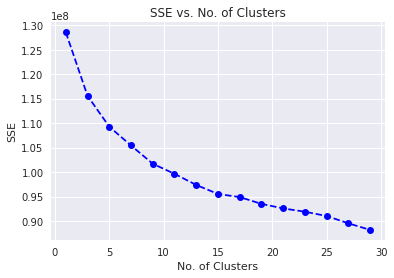

In [147]:
# Over a number of different cluster counts...
# run k-means clustering on the data and...
# compute the average within-cluster distances.  

scores = []
centers = list(range(1,30,2))

for center in centers:
    scores.append(get_kmeans_score(pca_azdias, center))


# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
plt.plot(centers, scores, linestyle='--', marker='o', color='b');
plt.xlabel('No. of Clusters');
plt.ylabel('SSE');
plt.title('SSE vs. No. of Clusters');

In [109]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.

K = 19
kmeans = KMeans(n_clusters = K )
model = kmeans.fit(pca_azdias)
pred = model.predict(pca_azdias)

### Discussion 3.1: Apply Clustering to General Population

I will be making a judgement call to pick K=19 as there isn't a distinct elbow in the above plot, but we can see the curve changes slightly around that point.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [110]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep=';')
customers.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2,4,1,5.0,5,1,5,1,2,2,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,1.0,2.0,1.0
1,-1,4,1,NaN,5,1,5,1,3,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-1,4,2,2.0,5,1,5,1,4,4,...,2.0,3.0,3.0,1.0,3.0,3.0,2.0,3.0,5.0,3.0
3,1,4,1,2.0,5,1,5,2,1,2,...,3.0,2.0,1.0,0.0,1.0,3.0,4.0,1.0,3.0,1.0
4,-1,3,1,6.0,3,1,4,4,5,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,3.0,5.0,1.0


In [111]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.


#Apply preprocessing, feature transformation
cust_data_clean = clean_data(customers,feat_info)

/opt/conda/lib/python3.6/site-packages/pandas/core/generic.py:5890: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [112]:
# double check if there are still missing values in the customer data
cust_data_clean.isnull().sum()

ALTERSKATEGORIE_GROB           233
ANREDE_KZ                        0
FINANZ_MINIMALIST                0
FINANZ_SPARER                    0
FINANZ_VORSORGER                 0
FINANZ_ANLEGER                   0
FINANZ_UNAUFFAELLIGER            0
FINANZ_HAUSBAUER                 0
GREEN_AVANTGARDE                 0
HEALTH_TYP                    2337
RETOURTYP_BK_S                3118
SEMIO_SOZ                        0
SEMIO_FAM                        0
SEMIO_REL                        0
SEMIO_MAT                        0
SEMIO_VERT                       0
SEMIO_LUST                       0
SEMIO_ERL                        0
SEMIO_KULT                       0
SEMIO_RAT                        0
SEMIO_KRIT                       0
SEMIO_DOM                        0
SEMIO_KAEM                       0
SEMIO_PFLICHT                    0
SEMIO_TRADV                      0
SOHO_KZ                          0
VERS_TYP                      2337
ANZ_PERSONEN                     0
ANZ_TITEL           

In [124]:
cust_data_clean.isnull().any().sum()

34

In [114]:
# preprocessing and feature transformation

# There are still missing values, and I will be dropping them
#cust_data_clean = cust_data_clean.dropna()

In [125]:
# There are still missing values, I will use an Imputer to handle them as in 
# https://scikit-learn.org/0.16/modules/generated/sklearn.preprocessing.Imputer.html

cust_replace_miss = Imputer(missing_values = np.nan, strategy='mean', axis=1) #impute missing values with the mean
cust_data_clean2 = pd.DataFrame(cust_replace_miss.fit_transform(cust_data_clean), columns = cust_data_clean.keys())

In [126]:
# verify if there are still missing values
cust_data_clean2.isnull().any().sum()

0

In [155]:
# Apply feature scaling and standardizing
#cust_data_clean3 = feature_scale.transform(cust_data_clean2)

In [127]:
# referenced: https://knowledge.udacity.com/questions/203980
# The customer data don't have the same number of columns to fit the data on, and will result in a mismatch
# To resolve this issue, I will do the following:

#I will now compare the two lists between customer data and azdias
azdias_list = azdias_new3.columns.tolist()
cust_list = cust_data_clean2.columns.tolist()

#sort both lists
azdias_list.sort()
cust_list.sort()

In [135]:
# Get the difference between the two lists
def list_diff(azdias_list, cust_list): 
    return (list(set(azdias_list) - set(cust_list))) 
print(list_diff(azdias_list, cust_list))

['GEBAEUDETYP_5.0']


In [136]:
# from the above, we can see that 'GEBAEUDETYP_5.0' is missing from the customer data and I will add it
cust_data_clean2['GEBAEUDETYP_5.0'] = 0

In [137]:
# verify if the missing column is now added to the customer data
cust_list2 = cust_data_clean2.columns.tolist()
print(list_diff(azdias_list, cust_list2))

[]


In [138]:
# I will now apply feature scaling and standardizing
cust_data_scaled = feature_scale.transform(cust_data_clean2)

In [139]:
# Applying PCA
cust_data_pca = pca_inst.transform(cust_data_scaled)

In [140]:
# Applying clustering
#model2 = kmeans.fit(cust_data_pca)
cust_data_cluster  = model.predict(cust_data_pca)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [141]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

# Get information about the general population
gen_pop = pd.Series(pred)
gen_pop_clusters = gen_pop.value_counts().sort_index()
pd.Series(gen_pop_clusters)

0     54491
1     43362
2     77012
3     25513
4     43539
5     33582
6     80873
7     20592
8     55153
9     26585
10    14582
11    46527
12    10501
13    32672
14    46974
15    39954
16    62629
17    57525
18    25895
dtype: int64

In [142]:
# Get information about customer data
customer_data = pd.Series(cust_data_cluster)
customer_data_clusters = customer_data.value_counts().sort_index()
pd.Series(customer_data_clusters)

0       366
1     11254
2      3546
3      1847
4     15748
5       370
6      6729
7     12955
8     29708
9      2075
10       43
11    10194
12        8
13     4194
14     2548
16       57
17    34326
18     5745
dtype: int64

In [143]:
# I will now calculate the proportion of the customer data and the general population

#Firstly, combine the customer_data_clusters and gen_pop_clusters
prop = pd.concat([gen_pop_clusters, customer_data_clusters],axis=1).reset_index()
prop.columns = ['Clusters', 'General', 'Customers']

#calculating the proportion of customer data and general poplulation
prop['General_proportion'] = prop['General']/prop['General'].sum()
prop['Customer_proportion'] = prop['Customers']/prop['Customers'].sum()

#view the proportions
prop

,Clusters,General,Customers,General_proportion,Customer_proportion
0,0,54491,366.0,0.068288,0.002583
1,1,43362,11254.0,0.054341,0.079414
2,2,77012,3546.0,0.096511,0.025022
3,3,25513,1847.0,0.031973,0.013033
4,4,43539,15748.0,0.054563,0.111126
5,5,33582,370.0,0.042085,0.002611
6,6,80873,6729.0,0.101350,0.047483
7,7,20592,12955.0,0.025806,0.091417
8,8,55153,29708.0,0.069117,0.209635
9,9,26585,2075.0,0.033316,0.014642


In [144]:
above_thres.shape[0]

93260

In [145]:
azdias.shape

(891221, 85)

In [146]:
azdias_new3.shape

(797961, 193)

In [147]:
cust_data_clean2.shape

(141713, 193)

In [148]:
# From step 1.1.3 above, I found out the those above and below my threshold(25) were qualitatively different.
# As a result of this, I would be treating this as an additional data cluster my analysis. 

# Get those values that were above the threshold for both the general population 
gen_above_thres_pop = len(above_thres)/azdias.shape[0]

# for customer data
cust_above_thres_pop = (customers.shape[0] - cust_data_clean2.shape[0])/customers.shape[0]

In [149]:
# I will be treating those values that were above the threshold as an additional cluster 
# and will now add the above to my proportions dataframe 
prop_new = prop.append(
                {'Clusters': -1, 
                 'General': above_thres.shape[0],
                 'Customers': cust_data_clean2.shape[0],
                 'General_proportion': gen_above_thres_pop,
                 'Customer_proportion': cust_above_thres_pop}, ignore_index=True
                )
prop_new

,Clusters,General,Customers,General_proportion,Customer_proportion
0,0.0,54491.0,366.0,0.068288,0.002583
1,1.0,43362.0,11254.0,0.054341,0.079414
2,2.0,77012.0,3546.0,0.096511,0.025022
3,3.0,25513.0,1847.0,0.031973,0.013033
4,4.0,43539.0,15748.0,0.054563,0.111126
5,5.0,33582.0,370.0,0.042085,0.002611
6,6.0,80873.0,6729.0,0.101350,0.047483
7,7.0,20592.0,12955.0,0.025806,0.091417
8,8.0,55153.0,29708.0,0.069117,0.209635
9,9.0,26585.0,2075.0,0.033316,0.014642


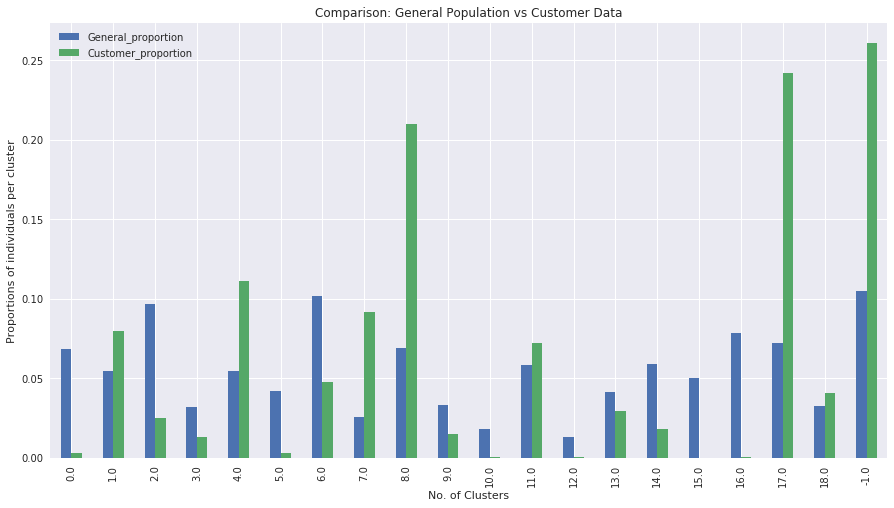

In [150]:
# Visualization for the individual dataset proportions,
# but also to visualize the ratios in cluster representation between groups
prop_new.plot(x='Clusters', y = ['General_proportion', 'Customer_proportion'], kind='bar', figsize=(15,8));
plt.xlabel('No. of Clusters')
plt.ylabel('Proportions of individuals per cluster')
plt.title('Comparison: General Population vs Customer Data')

plt.show()

### 1. What kinds of people are part of a cluster that is overrepresented in the customer data compared to the general population?

Cluster 7 is an example of overrepresentation given that I have very many people in my customer data but very few in the general population

##### Infering what kind of people might be represented by cluster 7

In [152]:
# view the centriod to see the most important principal components for cluster 7
centroid = model.cluster_centers_[7]
df_centroid = pd.DataFrame(centroid, columns= ['weight'])
df_centroid_sort = df_centroid.sort_values('weight', ascending=False)

df_centroid_sort.head()

,weight
2,9.506878
1,7.966007
0,5.693578
7,5.115695
3,3.894668


In [153]:
df_centroid_sort.tail()

,weight
23,-0.290869
14,-0.367042
6,-0.846566
8,-1.141322
9,-1.228051


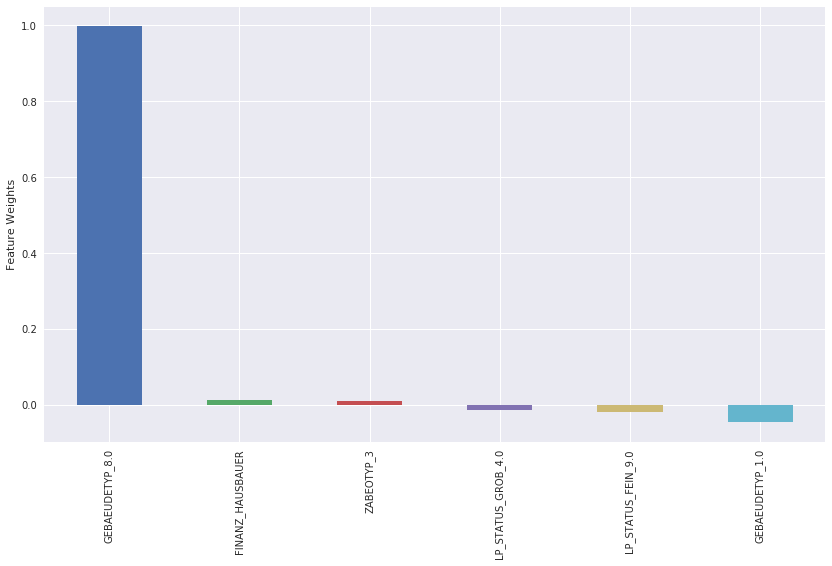

GEBAEUDETYP_8.0       0.9973
FINANZ_HAUSBAUER      0.0122
ZABEOTYP_3            0.0112
LP_STATUS_GROB_4.0   -0.0133
LP_STATUS_FEIN_9.0   -0.0184
GEBAEUDETYP_1.0      -0.0447
Name: 1, dtype: float64

In [154]:
# From the above, we can see that component 2 is highly positively correlated to cluster 7 and 
# component 9 is highly negatively correlated with cluster 7

# we will now find out what type of people are in these components in order to deduce which individuals are in cluster 7

#lets check out component 2
pca_results(cust_data_clean2, pca_inst, 2, 3)

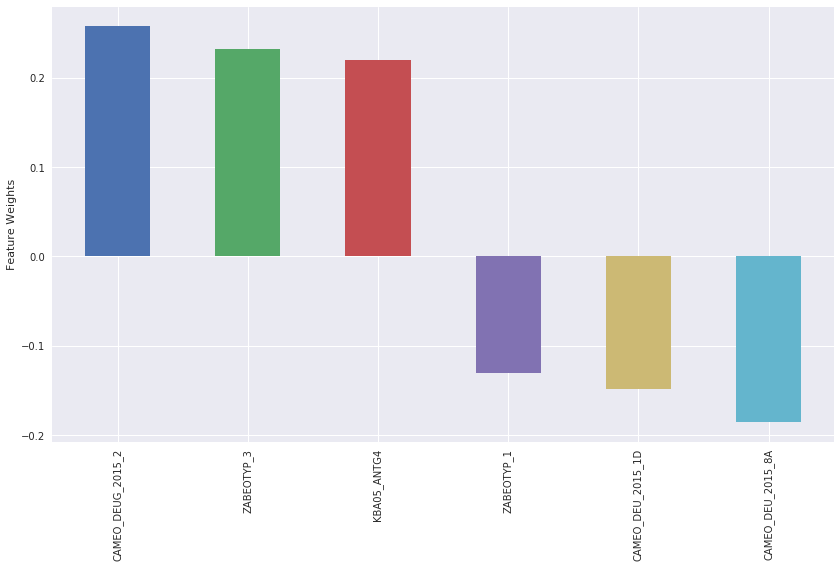

CAMEO_DEUG_2015_2    0.2576
ZABEOTYP_3           0.2324
KBA05_ANTG4          0.2197
ZABEOTYP_1          -0.1306
CAMEO_DEU_2015_1D   -0.1489
CAMEO_DEU_2015_8A   -0.1851
Name: 8, dtype: float64

In [155]:
#lets check out component 9
pca_results(cust_data_clean2, pca_inst, 9, 3)

### Observations:
**Component 2:**

Positive:

1. GEBAEUDETYP_8.0(0.9973):Type of building(mixed building without actually known company)
2. FINANZ_HAUSBAUER(0.0122): Financial typology, home ownership
3. ZABEOTYP_3(0.0112): Fair energy consumer

Negative:

1. LP_STATUS_GROB_4.0(-0.0133): Social status, rough scale(houseowners (maps to 8-9 in fine scale))
2. LP_STATUS_FEIN_9.0(-0.0184): Social status, fine scale(houseowners)
3. GEBAEUDETYP_1.0(-0.0447): Type of building(residential building)

**Component 9:**

Positive:

1. CAMEO_DEUG_2015_2(0.2576): Wealth / Life Stage Typology, rough scale(upper middleclass)
2. ZABEOTYP_3(0.2324): Energy consumption typology(fair supplied)
3. KBA05_ANTG4(0.2197): Number of 10+ family houses in the microcell

Negative:

1. ZABEOTYP_1(-0.1306): Energy consumption typology(green)
2. CAMEO_DEU_2015_1D(-0.1489): Wealth / Life Stage Typology, rough scale(Old Nobility)
3. CAMEO_DEU_2015_8A(-0.1851): Wealth / Life Stage Typology, rough scale(Multi-culteral)

**My Intuition:**

From the above, I observed that the overrepresented cluster (7) contains individuals that are upper middleclass home owners with over 10+ family houses and live in mixed buildings. These individuals aren't multi-cultural, nor green in their energy consumption and aren't old nobility.

### 2. What kinds of people are part of a cluster that is underrepresented in the customer data compared to the general population?

Cluster 0 is an example of underrepresentation given that I have very few people in my customer data but very many in the general population.

In [157]:
# view the centriod to see the most important principal components for cluster 0
centroid2 = model.cluster_centers_[0]
df_centroid2 = pd.DataFrame(centroid2, columns= ['weight'])
df_centroid_sort2 = df_centroid2.sort_values('weight', ascending=False)

df_centroid_sort2.head()

,weight
1,2.667900
3,2.315338
9,0.689474
13,0.512492
27,0.422259


In [158]:
df_centroid_sort2.tail()

,weight
20,-0.489604
6,-0.659430
4,-0.729430
2,-2.257439
0,-3.183581


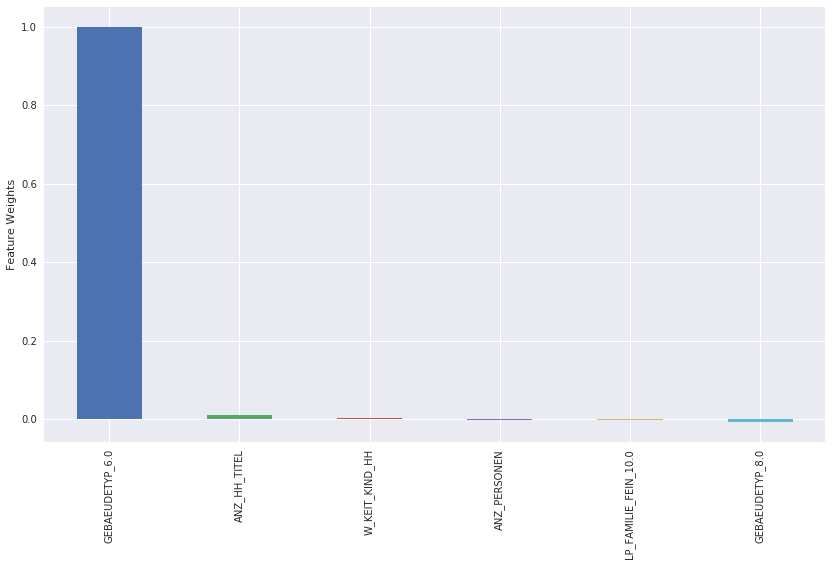

GEBAEUDETYP_6.0         0.9999
ANZ_HH_TITEL            0.0126
W_KEIT_KIND_HH          0.0031
ANZ_PERSONEN           -0.0021
LP_FAMILIE_FEIN_10.0   -0.0023
GEBAEUDETYP_8.0        -0.0072
Name: 0, dtype: float64

In [159]:
# From the above, we can see that component 1 is highly positively correlated to cluster 0 and 
# component 0 is highly negatively correlated with cluster 0

# we will now find out what type of people are in these components in order to deduce which individuals are in cluster 0

#lets check out component 1
pca_results(cust_data_clean2, pca_inst, 1, 3)

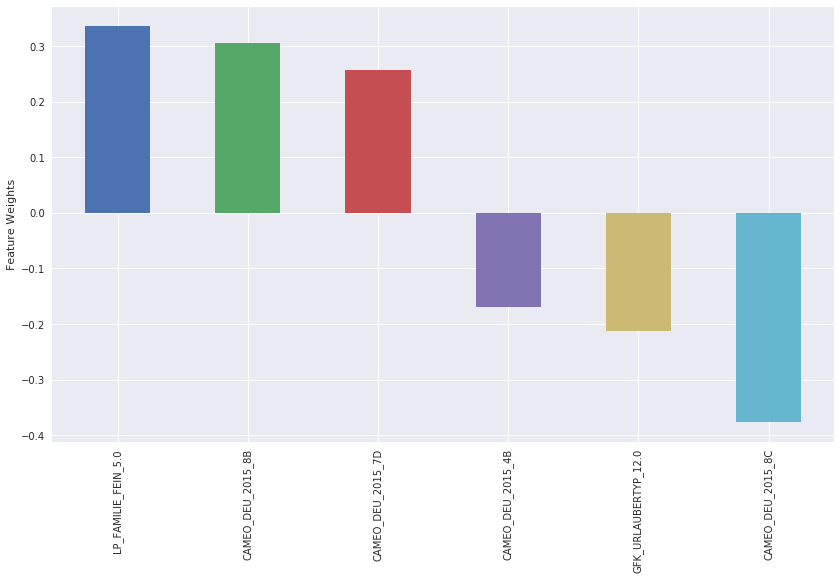

LP_FAMILIE_FEIN_5.0     0.3353
CAMEO_DEU_2015_8B       0.3051
CAMEO_DEU_2015_7D       0.2566
CAMEO_DEU_2015_4B      -0.1689
GFK_URLAUBERTYP_12.0   -0.2118
CAMEO_DEU_2015_8C      -0.3757
Name: 89, dtype: float64

In [160]:
#lets check out component 0
pca_results(cust_data_clean2, pca_inst, 0, 3)

### Observations:
**Component 1:**

Positive:

1. GEBAEUDETYP_6.0(0.9999): Type of building(mixed building without actually known household)
2. ANZ_HH_TITEL(0.0126): Number of professional academic title holders in building
3. W_KEIT_KIND_HH(0.0031): Likelihood of children in household

Negative:

1. ANZ_PERSONEN(-0.0021): Number of adults in household
2. LP_FAMILIE_FEIN_10.0(-0.0023): Family type, fine scale(two-generational household)
3. GEBAEUDETYP_8.0(-0.0072): Type of building(mixed building without actually known company)

**Component 0:**

Positive:

1. LP_FAMILIE_FEIN_5.0(0.3353): Family type, fine scale(single parent with child of full age)
2. CAMEO_DEU_2015_8B(0.3051): Wealth / Life Stage Typology, detailed scale(Young & Mobile)
3. CAMEO_DEU_2015_7D(0.2566): Wealth / Life Stage Typology, detailed scale(Rear Window)

Negative:

1. CAMEO_DEU_2015_4B(-0.1689): Wealth / Life Stage Typology, detailed scale(Family Life)
2. GFK_URLAUBERTYP_12.0(-0.2118): Vacation habits(Without vacation)
3. CAMEO_DEU_2015_8C(-0.3757): Wealth / Life Stage Typology, detailed scale(Prefab)

**My Intuition:**

From the above, I observed that the underrepresented cluster (0) contains young and mobile single parents with children of full age that live in mixed building without known household. These individuals don't really have a family life and usually go on vacation.

### Discussion 3.3: Compare Customer Data to Demographics Data

For this part, I only looked at one overrepresented and underrepresented clusters due to time contraints and would be making my conclusions based on that.

1. From my clustering analysis, I would suggest that the company targets individuals in cluster 0 as they may be good candidates of the mail-order sales since they are under represented (unpopular with the company). These are young and mobile single parents with children of full age so they are likely to want sales opportunities right away. The company may want to re-strategize the delivery of the mail-order sales to ensure it gets to them easily since they live in mixed building. These individuals also don't really have a family life, so they have less responsibility and since they usually go on vacation, they are may be interested in sales opportunities so as to save up for vacations with the left over finance they have.


2. Secondly, cluster 7 contains individuals that are upper middleclass home owners with over 10+ family houses and live in mixed buildings. These individuals aren't multi-cultural, nor green in their energy consumption and aren't old nobility. These individuals are relatively popular (overrepresented) with the mail-order company, and since they are upper middle class they may be interested in sales opportunities. However, the company may want to rethink their advertisement strategy with these set of individuals given that they live in mixed building and the mail-order may not get to them easily.

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.